# Predicting Kickstarter Campaign Success

![](../images/kickstarter-logo.jpg)

# Overview

Projects on kickstarter have a funding goal, where backers pledge to fund the project only if the total funding is met.  If the amount pledged is less than the goal, the project does not get funded and it fails.  When a project is successfully funded, the backers are charged the amount they pledged and the project creator gets the funds to carry out their project, while Kickstarter gets a commission.  In this project, we will examine the success rate of campaigns from the perspective of Kickstarter in order to understand the most important factors for campaign success.  This will allow Kickstarter to aid creators in hitting funding goals and maximize 

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import json
from glob import glob
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from src import datacleaning as dc
from src import modeling as md
pd.set_option('max_columns', None)

# EDA

In [2]:
# df = pd.DataFrame()
# for f in glob('../data/Kickstarter*.csv'):
#     df = pd.concat([df, pd.read_csv(f)])
# df.to_csv('..data/Kickstarter_full.csv', index = False)

In [3]:
df = pd.read_csv('../data/Kickstarter_full.csv')

In [4]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,2,I am building a website as a platform for stud...,"{""id"":362,""name"":""Makerspaces"",""slug"":""technol...",8,AU,Australia,1526014096,"{""id"":576665900,""name"":""Emma - Teaching Little...",AUD,$,True,USD,1528928562,False,NaN,0.713110,1000.0,2116213542,NaN,False,NaN,1526336562,"{""id"":1102170,""name"":""Geelong"",""slug"":""geelong...",STEAM Challenges for kids,NaN,"{""key"":""assets/021/192/015/169fac7e245d13c5b2c...",11.32,"{""id"":3378817,""project_id"":3378817,""state"":""in...",steam-challenges-for-kids,https://www.kickstarter.com/discover/categorie...,False,False,failed,1528928562,0.754091,"{""web"":{""project"":""https://www.kickstarter.com...",8.536309,domestic
1,43,"For my first solo museum exhibition, I'm const...","{""id"":288,""name"":""Installations"",""slug"":""art/i...",3390,US,the United States,1490746168,"{""id"":1570512397,""name"":""Mark Reamy"",""is_regis...",USD,$,True,USD,1493819063,False,NaN,1.000000,3000.0,162726099,NaN,False,NaN,1491227063,"{""id"":1123319,""name"":""Gwangju-Si"",""slug"":""gwan...",Moving Mountains - An Exhibition in South Korea,NaN,"{""key"":""assets/016/043/280/779386fd82d6830e626...",3390.00,"{""id"":2940021,""project_id"":2940021,""state"":""in...",moving-mountains-an-exhibition-in-south-korea,https://www.kickstarter.com/discover/categorie...,True,True,successful,1493819064,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3390.000000,domestic
2,243,"Jenn lives in an underground bunker, protected...","{""id"":302,""name"":""Thrillers"",""slug"":""film & vi...",28601,US,the United States,1411536270,"{""id"":579435811,""name"":""Steve Desmond"",""is_reg...",USD,$,True,USD,1415844585,False,NaN,1.000000,16500.0,1678056872,NaN,False,NaN,1413248985,"{""id"":2442047,""name"":""Los Angeles"",""slug"":""los...",Monsters - The Short Film,NaN,"{""key"":""assets/011/877/406/34b5aa93986724b6374...",28601.11,"{""id"":1376329,""project_id"":1376329,""state"":""in...",monsters-the-short-film,https://www.kickstarter.com/discover/categorie...,True,True,successful,1415844587,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28601.110000,domestic
3,2,I want to create a book that displays my work ...,"{""id"":278,""name"":""People"",""slug"":""photography/...",26,US,the United States,1420492380,"{""id"":528048907,""name"":""Brandi Carroll"",""is_re...",USD,$,True,USD,1423192306,False,NaN,1.000000,5000.0,1972792590,NaN,False,NaN,1420600306,"{""id"":2374330,""name"":""Caneyville"",""slug"":""cane...",Imagine,NaN,"{""key"":""assets/011/991/354/8497459c8c1bef38223...",26.00,"{""id"":1612632,""project_id"":1612632,""state"":""in...",imagine-0,https://www.kickstarter.com/discover/categorie...,False,False,failed,1423192306,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",26.000000,domestic
4,210,A series of hard enamel pins and accessories,"{""id"":26,""name"":""Crafts"",""slug"":""crafts"",""posi...",6516,GB,the United Kingdom,1593683203,"{""id"":926607047,""name"":""Laura Croft"",""slug"":""f...",GBP,£,False,USD,1598633946,False,NaN,1.301187,1000.0,928655800,NaN,False,NaN,1596214746,"{""id"":26279,""name"":""Lincoln"",""slug"":""lincoln-g...",Monsters and Maw Enamel Pins,NaN,"{""key"":""assets/029/762/429/cfde26eb92bacd30e93...",4919.00,"{""id"":4025596,""project_id"":4025596,""state"":""in...",monsters-and-maw-enamel-pins,https://www.kickstarter.com/discover/categorie...,True,False,successful,1598633946,1.298425,"{""web"":{""project"":""https://www.kickstarter.com...",6386.951345,domestic


In [5]:
df.state.value_counts(normalize = True)

successful    0.582305
failed        0.344952
canceled      0.041410
live          0.031334
Name: state, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219538 entries, 0 to 219537
Data columns (total 38 columns):
backers_count               219538 non-null int64
blurb                       219532 non-null object
category                    219538 non-null object
converted_pledged_amount    219538 non-null int64
country                     219538 non-null object
country_displayable_name    219538 non-null object
created_at                  219538 non-null int64
creator                     219538 non-null object
currency                    219538 non-null object
currency_symbol             219538 non-null object
currency_trailing_code      219538 non-null bool
current_currency            219538 non-null object
deadline                    219538 non-null int64
disable_communication       219538 non-null bool
friends                     312 non-null object
fx_rate                     219538 non-null float64
goal                        219538 non-null float64
id                          219

# Data Cleaning

In [7]:
country_names = list(df.country_displayable_name.value_counts().index)
country_codes = list(df.country.value_counts().index)
countries = list(zip(country_names, country_codes))

From the .info we see a few columns that can be dropped because they don't have enough data

- `friend`
- `is_backing`
- `is_starred`
- `permission`

Additionally, there are a few unneeded or redundant columns
- `photo`
- `id`
- `currency_symbol`
- `country_displayable_name`
- `disable_communication`
- `fx_rate`
- `converted_pledged_amount`
- `currency_trailing_code`
- `current_currency`

In [8]:
df = df.drop(columns = ['friends',
                        'is_backing',
                        'is_starred',
                        'permissions',
                        'photo',
                        'id',
                        'currency_symbol',
                        'country_displayable_name',
                        'disable_communication',
                        'converted_pledged_amount',
                        'fx_rate',
                        'currency_trailing_code',
                        'current_currency'
                       ]
            )

To deal with potential duplicate entries, rows with the same `blurb` and `launched_at` timestamp are dropped

In [9]:
df = df.drop_duplicates(subset = ['blurb', 'launched_at'])

We need to convert the date columns with object dtype unix timestamps into datetime objects.

In [10]:
dc.datetime_conversion(df)

To convert the `goal` feature into a consistent currency, the `usd_goal` is created using `static_usd_rate`

In [11]:
df['usd_goal'] = df.static_usd_rate * df.goal

In [12]:
df.currency.value_counts()

USD    133128
GBP     21420
EUR     14356
CAD      9035
AUD      4546
MXN      2775
SEK      1351
HKD      1203
NZD       856
DKK       843
SGD       736
CHF       666
JPY       490
NOK       466
PLN         4
Name: currency, dtype: int64

## Feature Engineering

- has prior success
- rate of funding (fast funder, slow funder)
- number of words in blurb


#### Has prior success

From the creator dictionary string, the user id is pulled, and then that id is used to check if that user has more than 1 successful campaign.

In [13]:
df['creator_id'] = df.creator.apply(lambda x: int(x[6:6+dc.checkit(x[6:])]))
temp = df.creator_id.value_counts()
df['has_prior_success'] = [1 if temp.loc[x] > 1 else 0 for x in df.creator_id]

In [14]:
df.has_prior_success.value_counts()

0    147580
1     44295
Name: has_prior_success, dtype: int64

#### Project length

We want to determine if the length of a project has an effect on the success of the campaign.

In [15]:
df['project_length'] = df.deadline - df.launched_at
df.project_length = df.project_length.apply(lambda x: x.days)

In [16]:
len(df.blurb[0].split())

21

#### Blurb Length

To see if the number of words in the blurb is important to the success of a project.

In [17]:
df['blurb_length'] = [len(str(x).split()) for x in df.blurb]

#### Pledge per backer

In [18]:
df.backers_count.value_counts()

0       15885
1       15434
2       10694
3        7331
4        5255
        ...  
2373        1
4422        1
6599        1
3013        1
1726        1
Name: backers_count, Length: 3410, dtype: int64

In [19]:
df['pledge_per_backer'] = np.where(df.backers_count == 0, 0, df.usd_pledged / df.backers_count)

#### Goal timedelta

In [20]:
df['goal_needed_per_day'] = df.usd_goal / df.project_length
df['raised_per_day'] = df.usd_pledged / df.project_length
df.columns

Index(['backers_count', 'blurb', 'category', 'country', 'created_at',
       'creator', 'currency', 'deadline', 'goal', 'is_starrable',
       'launched_at', 'location', 'name', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type', 'usd_goal',
       'creator_id', 'has_prior_success', 'project_length', 'blurb_length',
       'pledge_per_backer', 'goal_needed_per_day', 'raised_per_day'],
      dtype='object')

In [21]:
df.usd_type.value_counts()

domestic         146370
international     45263
Name: usd_type, dtype: int64

#### Category Dictionary

In [22]:
df.category = df.category.apply(json.loads)
df['category_name'] = df.category.apply(lambda x: x['name'])

## Categorical Columns

In [23]:
dummy_cols = [
    'country',
    'is_starrable',
    'spotlight',
    'staff_pick',
    'state',
    'category_name',
    'usd_type'
]
df = pd.get_dummies(df,
                    columns = dummy_cols,
                    drop_first = True)

## Live, canceled dfs

In [24]:
live_df = df.loc[df.state_live == 1]
df = df.drop(df.loc[df.state_live == 1].index).drop(columns = 'state_live')
cancelled_df = df.loc[(df.state_successful == 0) & (df.state_failed == 0)]
df = df.drop(columns = 'state_failed')

## Feature elimination

In [25]:
drop_columns = ['backers_count',
                'blurb',
                'category',
                'created_at',
                'creator',
                'deadline', 
                'launched_at',
                'location',
                'name',
                'pledged',
                'profile',
                'slug',
                'source_url',
                'state_changed_at',
                'static_usd_rate',
                'urls',
                'goal',
                'usd_pledged',
                'creator_id',
                'pledge_per_backer',
                'currency',
                'raised_per_day',
                'spotlight_True']
df = df.drop(columns = drop_columns, axis = 1)
df.reset_index(drop = True, inplace = True)

# Train Test Split

The dataframe is randomly separated into training/test data in a 80:20 split. The model will be fit on the training set, then then used to predict the target of the test set.  A random seed value is included for preproducibility.

In [26]:
data = md.tts(df)
columns = data[0].columns

# Modelling

## Logistic Regression

In [114]:
logreg = LogisticRegression(
    class_weight = 'balanced',
    random_state = 69, 
    solver = 'liblinear')
logreg = md.fitmodel(logreg, data)
md.get_scores(logreg, data)

Test F1:  0.521         Train F1: 0.519
Test Acc: 0.562         Train Acc: 0.558
Test Recall: 0.433      Train Recall: 0.431
Test Precision: 0.656   Train Precision: 0.653


In [145]:
pd.DataFrame(
    logreg.coef_[0], columns).rename(
    columns={0:'coef'}).sort_values(
    by='coef', ascending = False).head(10)

,coef
blurb_length,0.000832
project_length,0.000703
staff_pick_True,0.000057
has_prior_success,0.000053
country_US,0.000048
usd_type_international,0.000026
goal_needed_per_day,0.000014
country_GB,0.000010
category_name_Documentary,0.000007
category_name_Video Games,0.000007


## Random Forest

In [108]:
forest = RandomForestClassifier(
    random_state = 69,
    n_estimators = 100,
    class_weight = 'balanced',
    n_jobs = -1,
    min_samples_leaf = 5,
    min_samples_split = 10,
    max_leaf_nodes = 1000,
)
forest = md.fitmodel(forest, data)
md.ft_importance(forest, columns)

,0
staff_pick_True,0.152501
usd_goal,0.078635
goal_needed_per_day,0.073473
project_length,0.052241
has_prior_success,0.047282
category_name_Country & Folk,0.026433
category_name_Nonfiction,0.025674
category_name_Documentary,0.025209
category_name_Indie Rock,0.025201
category_name_Rock,0.024690


In [109]:
md.get_scores(forest, data)

Test F1:  0.809         Train F1: 0.823
Test Acc: 0.804         Train Acc: 0.818
Test Recall: 0.752      Train Recall: 0.765
Test Precision: 0.874   Train Precision: 0.891


In [110]:
forest

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=1000, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=69, verbose=0, warm_start=False)

## XG Boost

In [111]:
xgb = XGBClassifier(random_state = 69)
xgb = md.fitmodel(xgb, data)
md.ft_importance(xgb, columns)

,0
category_name_Web,0.040698
usd_goal,0.036732
category_name_Indie Rock,0.034742
category_name_Nonfiction,0.034732
category_name_Shorts,0.033980
category_name_Country & Folk,0.033724
category_name_Rock,0.032309
category_name_Children's Books,0.032233
category_name_Apparel,0.031956
category_name_Product Design,0.031519


# Gridsearches

## Forest GS

In [ ]:
params = {
    'n_estimators' : [100],
    'max_features': ['auto'],
    'criterion' : ['gini'],
#     'max_depth' : range(2,31,2),
    'min_samples_leaf' : range(3,13,3),
    'min_samples_split' : range(2,33,4),
    'max_leaf_nodes' : [2000],
}
forest = RandomForestClassifier(
    class_weight = 'balanced',
    random_state = 69,
    n_jobs = -1,
)
forestGS = GridSearchCV(
    estimator = forest,
    param_grid = params,
    cv = 5,
    scoring = 'recall',
    verbose = 1,
    n_jobs = -1
)
forestGS.fit(data[0], data[2])
forestGS.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
md.get_scores(forestGS.best_estimator_, data)

### L1 Log reg

In [147]:
params = {
    'penalty' : ['l1'],
    'C' : [130],
    'class_weight' : ['balanced'],
    'solver' : ['liblinear']
}
logreg = LogisticRegression(
    max_iter = 100,
    random_state = 69)
logregGS = GridSearchCV(
    estimator = logreg,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    scoring = 'f1',
    verbose = 1,
)
logregGS.fit(data[0],data[2])
logregGS.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


LogisticRegression(C=130, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=69, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [148]:
md.get_scores(logregGS.best_estimator_, data)

Test F1:  0.8         Train F1: 0.806
Test Acc: 0.798         Train Acc: 0.803
Test Recall: 0.731      Train Recall: 0.736
Test Precision: 0.883   Train Precision: 0.891


In [153]:
pd.DataFrame(
    logregGS.best_estimator_.coef_[0], columns).rename(
    columns={0:'coef'}).sort_values(
    by='coef', ascending = False).head()

,coef
category_name_Video Games,45.749020
category_name_Tabletop Games,19.109434
category_name_Documentary,17.772714
category_name_Rock,13.072856
category_name_Product Design,12.885767


### L2 Log reg

In [87]:
# params = {
#     'penalty' : ['l2'],
#     'C' : [120],
#     'class_weight' : ['balanced'],
#     'solver' : ['newton-cg']
# }
# logreg = LogisticRegression(
#     max_iter = 100,
#     random_state = 69)
# logregGS = GridSearchCV(
#     estimator = logreg,
#     param_grid = params,
#     cv = 2,
#     n_jobs = -1,
#     scoring = 'f1',
#     verbose = 1,
# )
# logregGS.fit(data[0],data[2])
# logregGS.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   41.3s finished
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=120, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=69, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
# md.get_scores(logregGS.best_estimator_, data)

Test F1:  0.8         Train F1: 0.805
Test Acc: 0.798         Train Acc: 0.802
Test Recall: 0.731      Train Recall: 0.735
Test Precision: 0.882   Train Precision: 0.889


# Results

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.891
Random Forest: ROC AUC=0.896
XGBoost: ROC AUC=0.864


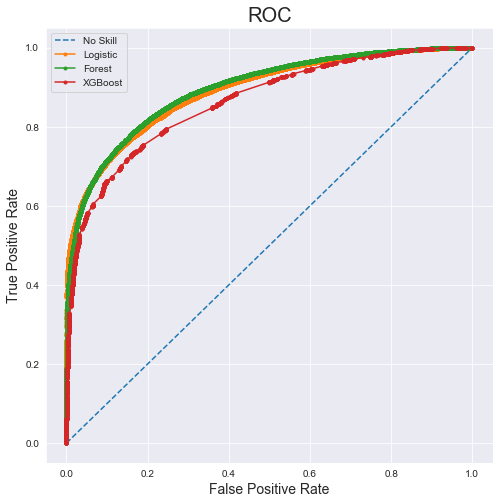

In [113]:
md.generate_ROC(data, logregGS.best_estimator_, forest, xgb, 'ROC')